In [1]:
import pandas as pd
import numpy as np
import pickle

import tensorflow as tf
from collections import Counter
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Input

import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from nltk.tokenize import TweetTokenizer

In [3]:
# Load in clean data
data = pd.read_pickle('data/input_data.pkl')
data.head(10)

,input_text,response_output
0,they do to,they do not
1,she okay,i hope so
2,wow,let us go
3,no,okay youre gonna need to learn how to lie
6,what crap,me this endless blonde babble i am like boring...
7,do you listen to this crap,what crap
8,but,you always been this selfish
9,then that is all you had to say,but
10,well no,then that is all you had to say
11,i wa,you never wanted to go out with me did you


In [4]:

# Append start and end to each response_output
data['response_output'] = '<start> ' + data['response_output'].astype(str) + ' <end>'
data.head(3)

,input_text,response_output
0,they do to,<start> they do not <end>
1,she okay,<start> i hope so <end>
2,wow,<start> let us go <end>


In [5]:

# Initialize tokenizers
tokenizer_input = Tokenizer(filters='', oov_token='<unk>')
tokenizer_target = Tokenizer(filters='', oov_token='<unk>')

tokenizer_input.fit_on_texts(data['input_text'].values)
tokenizer_target.fit_on_texts(data['response_output'].values)

input_vocab = tokenizer_input.word_index.keys()
target_vocab = tokenizer_target.word_index.keys()
print(f'input vocab size: {len(input_vocab)}, target vocab size: {len(target_vocab)}')


input vocab size: 25828, target vocab size: 43782


In [6]:

max_length = 40

# Tokenize and pad data
input_seqs = tokenizer_input.texts_to_sequences(data['input_text'])
input_seqs_padded = pad_sequences(input_seqs, maxlen=max_length, padding='post')
encoder_input = np.array(input_seqs_padded)
print(f'Encoder input shape: {encoder_input.shape}')

target_seqs = tokenizer_target.texts_to_sequences(data['response_output'])
target_seqs_padded = pad_sequences(target_seqs, maxlen=max_length, padding='post')
decoder_input = np.array(target_seqs_padded)
print(f'Decoder input shape: {target_seqs_padded.shape}')

# Create decoder target data
decoder_target_lines = []
for line in target_seqs:
    # Take every token after the <start> token
    decoder_target_lines.append(line[1:])
    
decoder_target_seqs = pad_sequences(decoder_target_lines, maxlen=max_length, padding='post')
decoder_target = np.array(decoder_target_seqs)
print(f'Decoder target shape: {decoder_target.shape}')

# Save tokenizers to pickle file
with open('tokenizer_input.pkl', 'wb') as file:
    pickle.dump(tokenizer_input, file)

with open('tokenizer_target.pkl', 'wb') as file:
    pickle.dump(tokenizer_target, file)


Encoder input shape: (450680, 40)
Decoder input shape: (450680, 40)
Decoder target shape: (450680, 40)


In [6]:

# Train and validation split
from sklearn.model_selection import train_test_split

encoder_input_train, encoder_input_val, decoder_input_train, decoder_input_val, decoder_target_train, decoder_target_val = train_test_split(
    encoder_input, decoder_input, decoder_target, test_size=0.2, random_state=42
)


In [7]:

glove_files = ['glove.6B.50d.txt', 'glove.6B.100d.txt', 'glove.6B.200d.txt', 'glove.6B.300d.txt']

# Load in GloVe pre trained word embeddings
glove_model = {}

for file_path in glove_files:
    with open(f'{file_path}', 'r', encoding='utf-8') as file:
        for line in file:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            glove_model[word] = vector


In [8]:

vector_dim = len(next(iter(glove_model.values())))

# Initialize encoder embedding matrix
enc_embedding_matrix = np.zeros((len(tokenizer_input.word_index) + 1, vector_dim))

for word, i in tokenizer_input.word_index.items():
    if word in glove_model:
        enc_embedding_matrix[i] = glove_model[word]

# Initialize decoder embedding matrix
dec_embedding_matrix = np.zeros((len(tokenizer_target.word_index) + 1, vector_dim))

for word, i in tokenizer_target.word_index.items():
    if word in glove_model:
        dec_embedding_matrix[i] = glove_model[word]


**Model**

In [9]:
# Hyperparameters
input_vocab_size = len(input_vocab) + 1
target_vocab_size = len(target_vocab) + 1

# Model encoder
encoder_inputs = tf.keras.layers.Input(shape=(None , ))
# Use GloVe embeddings
enc_embedding_layer =  tf.keras.layers.Embedding(
    input_dim=input_vocab_size,
    output_dim=300,
    weights=[enc_embedding_matrix],
    input_length=max_length,
    trainable=False,
    mask_zero=True,
)
encoder_embedding = enc_embedding_layer(encoder_inputs)
encoder_outputs , state_h , state_c = tf.keras.layers.LSTM(200, return_state=True)(encoder_embedding)
encoder_states = [state_h , state_c]

# Model decoder
decoder_inputs = tf.keras.layers.Input(shape=(None ,  ))
dec_embedding_layer =  tf.keras.layers.Embedding(
    input_dim=target_vocab_size,
    output_dim=300,
    weights=[dec_embedding_matrix],
    input_length=max_length,
    trainable=False,
    mask_zero=True,
)
decoder_embedding = dec_embedding_layer(decoder_inputs)
decoder_lstm = tf.keras.layers.LSTM(200, return_state=True, return_sequences=True)
decoder_outputs , _ , _ = decoder_lstm (decoder_embedding, initial_state=encoder_states)
decoder_dense = tf.keras.layers.Dense(target_vocab_size, activation=tf.keras.activations.softmax)
output = decoder_dense (decoder_outputs)

# Define the model
model = tf.keras.models.Model([encoder_inputs, decoder_inputs], output )
model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='sparse_categorical_crossentropy')
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None)]               0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, None)]               0         []                            
                                                                                                  
 embedding (Embedding)       (None, None, 300)            3372600   ['input_1[0][0]']             
                                                                                                  
 embedding_1 (Embedding)     (None, None, 300)            3799500   ['input_2[0][0]']             
                                                                                              

In [10]:

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
history = model.fit(
    [encoder_input_train, decoder_input_train], decoder_target_train,
    validation_data=([encoder_input_val, decoder_input_val], decoder_target_val),
    batch_size=50, epochs=50, callbacks=[early_stopping]
)

# Save model, model weights, and model history
model.save('model.h5')
model.save_weights('model_weights.h5')

with open('model_history.pkl', 'wb') as file:
    pickle.dump(history.history, file)


Epoch 1/50
3912/3912 [==============================] - 64s 14ms/step - loss: 4.9094 - val_loss: 4.6082
Epoch 2/50
3912/3912 [==============================] - 53s 14ms/step - loss: 4.5167 - val_loss: 4.4517
Epoch 3/50
3912/3912 [==============================] - 53s 14ms/step - loss: 4.3966 - val_loss: 4.3661
Epoch 4/50
3912/3912 [==============================] - 54s 14ms/step - loss: 4.3151 - val_loss: 4.2993
Epoch 5/50
3912/3912 [==============================] - 53s 14ms/step - loss: 4.2458 - val_loss: 4.2372
Epoch 6/50
3912/3912 [==============================] - 54s 14ms/step - loss: 4.1829 - val_loss: 4.1801
Epoch 7/50
3912/3912 [==============================] - 53s 14ms/step - loss: 4.1209 - val_loss: 4.1260
Epoch 8/50
3912/3912 [==============================] - 53s 14ms/step - loss: 4.0617 - val_loss: 4.0657
Epoch 9/50
3912/3912 [==============================] - 53s 14ms/step - loss: 4.0043 - val_loss: 4.0190
Epoch 10/50
3912/3912 [==============================] - 54s 14m

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


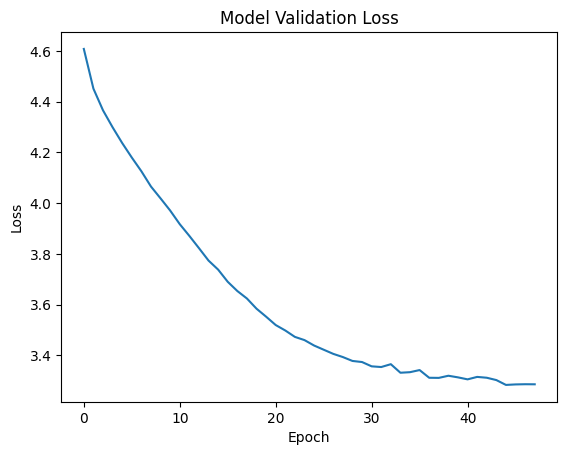

In [11]:

# Plot loss
plt.plot(history.history['val_loss'])
plt.title('Model Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()


In [12]:

''' Define inference model to use encoder and decoder from the model'''
def make_inference_models():

    encoder_model = tf.keras.models.Model(encoder_inputs, encoder_states)

    decoder_state_input_h = tf.keras.layers.Input(shape=(200, ))
    decoder_state_input_c = tf.keras.layers.Input(shape=(200, ))

    decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

    decoder_outputs, state_h, state_c = decoder_lstm(
        decoder_embedding , initial_state=decoder_states_inputs
    )
    decoder_states = [state_h, state_c]
    decoder_outputs = decoder_dense(decoder_outputs)

    decoder_model = tf.keras.models.Model(
        [decoder_inputs] + decoder_states_inputs,
        [decoder_outputs] + decoder_states
    )

    return encoder_model, decoder_model


In [13]:

''' Turn a string into padded, tokenized data that the encoder can use'''
def str_to_tokens(sentence):
    words = sentence.lower().split()
    tokens_list = list()
    for word in words:
        if word in tokenizer_input.word_index:
            tokens_list.append(tokenizer_input.word_index[word])
        else:
            tokens_list.append(tokenizer_input.word_index['<unk>'])
    return pad_sequences([tokens_list], maxlen=max_length , padding='post')


# Initialize encoder and decoder inference models
enc_model, dec_model = make_inference_models()


''' This loop gets input from the user and gets a response from chatbot'''
for _ in range(10):
    
    # Predict state values from input
    states_values = enc_model.predict(str_to_tokens(input('Say something: ' )))
    
    # Initialize target sequence as empty and give it start token
    empty_target_seq = np.zeros((1, 1))
    empty_target_seq[0, 0] = tokenizer_target.word_index['<start>']
    
    stop_condition = False
    decoded_sentence = ''

    while not stop_condition:
        # Decode the model's response
        dec_outputs, h, c = dec_model.predict([empty_target_seq] + states_values)
        
        # Get index of the next predicted word
        sampled_word_index = np.argmax(dec_outputs[0, -1, :])
        sampled_word = None

        # Find where the indices match up and get predicted word
        for word, index in tokenizer_target.word_index.items() :
            if sampled_word_index == index :
                decoded_sentence += ' {}'.format(word)
                sampled_word = word
        
        # If model predict end token or if over 40 tokens long end model response
        if sampled_word == '<end>' or len(decoded_sentence.split()) > max_length:
            stop_condition = True

        # Reset target sequence
        empty_target_seq = np.zeros((1, 1))
        empty_target_seq[0, 0] = sampled_word_index
        
        # Update state values 
        states_values = [h, c]

    print(decoded_sentence)

Say something: hi
1/1 [==============================] - 0s 22ms/step
 hi <end>
Say something: hello
1/1 [==============================] - 0s 21ms/step
 hello <end>
Say something: what is up
1/1 [==============================] - 0s 22ms/step
 nothing much what is going on <end>
Say something: what up dude
1/1 [==============================] - 0s 22ms/step
 well i am going to be back <end>
Say something: i love you
1/1 [==============================] - 0s 22ms/step
 i love you too <end>
Say something: aww thanks
1/1 [==============================] - 0s 22ms/step
 i am not sure i am not sure <end>
Say something: thank you
1/1 [==============================] - 0s 22ms/step
 i am so happy for you <end>
Say something: happy for me?
1/1 [==============================] - 0s 23ms/step
 i am not sure i am not sure <end>
Say something: not sure about what
1/1 [==============================] - 0s 22ms/step
 i am not sure <end>
Say something: well bye now
1/1 [=============================


This model definitely shows some promise, as it can correctly respond to some basic phrases, like "I love you" and "what is up." Even when it responds incorrectly, the sentences are still comprehensive, which is good. 

This model's performance can only be increased in a few ways. Increasing the training data size and making the model's architecture more complex are the best methods of doing so. Unfortunately, adding to the model's architecture with only one more LSTM layer in the encoder and decoder causes the training time to increase almost tenfold. Also, increasing the training data size has  diminishing returns on the increase of the model's performance, requiring me to significantly increase the amount of data to see any significant improvement. To do either of these, I would need a powerful GPU...
